## **Data Loading**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
print(len(os.listdir('drive/My Drive/Colab Notebooks/A3_Dataset/dataset1/images_prepped_train')))
print(len(os.listdir('drive/My Drive/Colab Notebooks/A3_Dataset/dataset1/images_prepped_test')))
     

367
101


In [ ]:
print(len(os.listdir('drive/My Drive/Colab Notebooks/A3_Dataset/dataset1/annotations_prepped_train')))
print(len(os.listdir('drive/My Drive/Colab Notebooks/A3_Dataset/dataset1/annotations_prepped_test')))
     

377
101


In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import albumentations as A

def load_data():
    # Step 1: Data Preprocessing
    image_dir = 'drive/My Drive/Colab Notebooks/A3_Dataset/dataset1/images_prepped_train'
    annotation_dir = 'drive/My Drive/Colab Notebooks/A3_Dataset/dataset1/annotations_prepped_train'
    image_size = (256, 256)  # Resize images to (256, 256)

    images = []
    annotations = []

    # Read and preprocess images and annotations
    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        annotation_path = os.path.join(annotation_dir, filename)
        
        # Read and resize image
        image = cv2.imread(image_path)
        image = cv2.resize(image, image_size)
        image = image / 255.0  # Normalize pixel values between 0 and 1
        
        # Read and resize annotation
        annotation = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
        annotation = cv2.resize(annotation, image_size)
        
        images.append(image)
        annotations.append(annotation)

    # Step 2: Train-Test Split
    images_train, images_val, annotations_train, annotations_val = train_test_split(images, annotations, test_size=0.2, random_state=42)

    images_val = np.array(images_val)
    annotations_val= np.array(annotations_val)
    annotations_val = np.expand_dims(annotations_val, axis=-1)
    
    return images_train,images_val,annotations_train,annotations_val




In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import albumentations as A

def load_test_data():
    # Step 1: Data Preprocessing
    image_dir = 'drive/My Drive/Colab Notebooks/A3_Dataset/dataset1/images_prepped_test'
    annotation_dir = 'drive/My Drive/Colab Notebooks/A3_Dataset/dataset1/annotations_prepped_test'
    image_size = (256, 256)  # Resize images to (256, 256)

    images = []
    annotations = []

    # Read and preprocess images and annotations
    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        annotation_path = os.path.join(annotation_dir, filename)
        
        # Read and resize image
        image = cv2.imread(image_path)
        image = cv2.resize(image, image_size)
        image = image / 255.0  # Normalize pixel values between 0 and 1
        
        # Read and resize annotation
        annotation = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
        annotation = cv2.resize(annotation, image_size)
        
        images.append(image)
        annotations.append(annotation)

    # Step 2: Train-Test Split
    

    images = np.array(images)
    annotations= np.array(annotations)
    annotations = np.expand_dims(annotations, axis=-1)
    
    return images,annotations




## **Data Augmentation**

In [4]:
def augment_train_data(images_train,annotations_train):
  
  # Step 4: Data Augmentation (Optional)
    augmentation = A.Compose([
        A.HorizontalFlip(p=0.5),  # Randomly flip images horizontally with a probability of 0.5
        A.VerticalFlip(p=0.5),  # Randomly flip images vertically with a probability of 0.5
        A.RandomRotate90(p=0.5),  # Randomly rotate images by 90 degrees with a probability of 0.5
        A.RandomBrightnessContrast(p=0.2),  # Randomly adjust brightness and contrast of images with a probability of 0.2
        A.GaussianBlur(p=0.1),  # Apply Gaussian blur with a probability of 0.1
    ])

    # Apply augmentation to training images and annotations
    #augmented_images_train = []
    #augmented_annotations_train = []

    for i in range(0,len(images_train)):
      image = (images_train[i] * 255).astype(np.uint8)  # Convert image to uint8
      annotation = (annotations_train[i] * 255).astype(np.uint8)  # Convert annotation to uint8

      augmented = augmentation(image=image, mask=annotation)
      images_train.append(augmented['image'])
      annotations_train.append(augmented['mask'])

    # Step 3: Data Formatting
    images_train = np.array(images_train)
    annotations_train = np.array(annotations_train)
    annotations_train = np.expand_dims(annotations_train, axis=-1)

    #images_train.append(augmented_images_train)
    #annotations_train.append(augmented_annotations_train)
    return images_train, annotations_train

## **Visualizing data**

In [ ]:
import matplotlib.pyplot as plt

# Function to display images and annotations
def display_samples(images, annotations, num_samples):
    fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(12, 12))

    for i in range(num_samples):
        image = images[i]
        annotation = annotations[i]

        # Plot the image
        axes[i][0].imshow(image)
        axes[i][0].axis('off')
        axes[i][0].set_title('Image')

        # Plot the annotation mask
        axes[i][1].imshow(annotation.squeeze(), cmap='viridis')
        axes[i][1].axis('off')
        axes[i][1].set_title('Annotation')

    plt.tight_layout()
    plt.show()




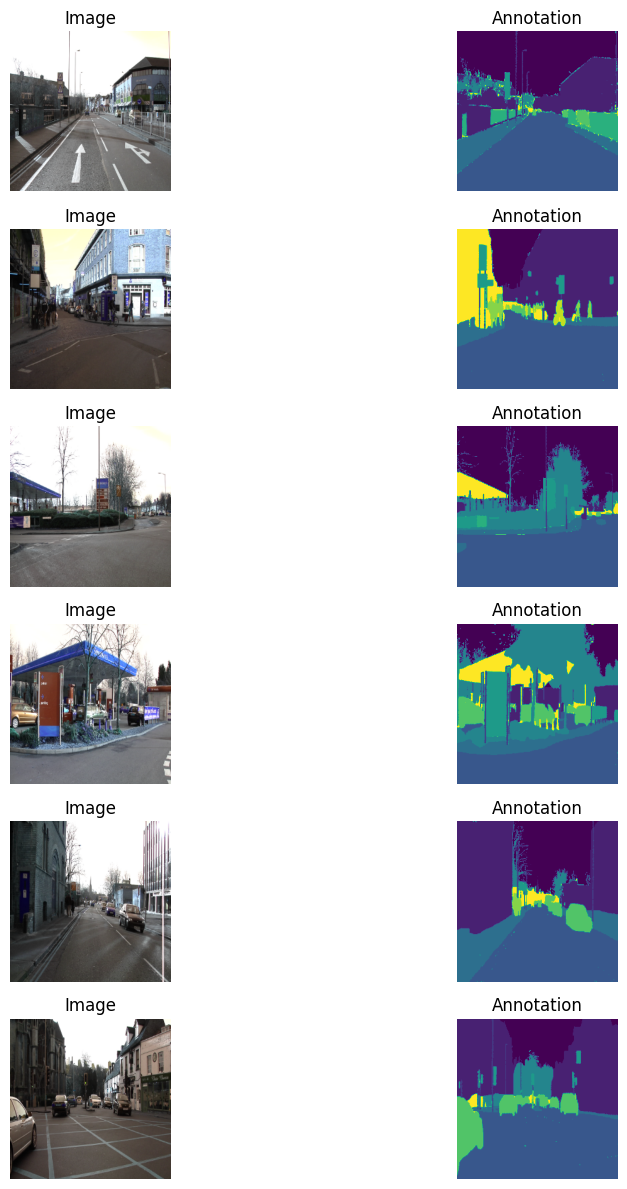

In [ ]:
# Display samples from the train dataset
display_samples(images_train, annotations_train, num_samples=6)

## **Model creation - efficient net base**

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0



def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

def Effienet_base_unet(input_shape):
    
    inputs = Input(input_shape)

    #Pre-trained Encoder 
    encoder = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = encoder.get_layer("input_1").output                      
    s2 = encoder.get_layer("block2a_expand_activation").output    
    s3 = encoder.get_layer("block3a_expand_activation").output    
    s4 = encoder.get_layer("block4a_expand_activation").output    

    b1 = encoder.get_layer("block6a_expand_activation").output    

    #decoder 
    d1 = decoder_block(b1, s4, 512)                              
    d2 = decoder_block(d1, s3, 256)                               
    d3 = decoder_block(d2, s2, 128)                               
    d4 = decoder_block(d3, s1, 64)                                

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="EfficientNetB0_UNET")

    return model

#ref link: https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/tree/main/TensorFlow

## **Evaluation metrics**

In [12]:
import keras.backend as K


# Calculating dice coefficient
def dice_coeff(y_true,y_pred,smooth=1):
  intersection=K.sum(y_true*y_pred,axis=[1,2,3])
  union=K.sum(y_true,axis=[1,2,3])+K.sum(y_pred,axis=[1,2,3])
  dice=K.mean((2.*intersection+smooth)/(union+smooth))
  return dice

# Calculating Sensitivty
def sensitivity(y_true,y_pred):
  TP=K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  PP=K.sum(K.round(K.clip(y_true,0,1)))
  return TP/(PP+K.epsilon())

#Calculating Specificity
def specificity(y_true,y_pred):
  TN=K.sum(K.round(K.clip((1-y_true)*(1-y_pred),0,1)))
  NN=K.sum(K.round(K.clip((1-y_true),0,1)))
  return TN/(NN+K.epsilon())

## **Pipeline**

In [4]:
images_train,images_val,annotations_train,annotations_val=load_data()
images_train, annotations_train=augment_train_data(images_train,annotations_train)


In [6]:
annotations_val=annotations_val.astype(np.float)
annotations_train=annotations_train.astype(np.float)

<ipython-input-6-5b263a47a5f2>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  annotations_val=annotations_val.astype(np.float)
<ipython-input-6-5b263a47a5f2>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  annotations_train=annotations_train.astype(np.float)


In [ ]:
len(images_train)


586

In [7]:

input_shape = (256, 256, 3)
model = Effienet_base_unet(input_shape)
model.summary()

Model: "EfficientNetB0_UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['normalization

In [8]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm


ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0,

## **Training**

In [9]:
batch_size=32
# Create a callback that saves the model's weights
checkpt = tf.keras.callbacks.ModelCheckpoint(filepath="drive/My Drive/Colab Notebooks/A3_Dataset/checkpoints/base2_{epoch:03d}.ckpt",save_weights_only=True,save_freq=4*batch_size)


In [10]:
model.compile(optimizer='adam',
              loss=sm.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [11]:
output=model.fit(x=images_train,y=annotations_train,batch_size=32,epochs=1,verbose=1,validation_data=(images_val,annotations_val),callbacks=[checkpt])


10/10 [==============================] - 1475s 143s/step - loss: 3.5969e-07 - accuracy: 0.2408 - val_loss: 3.5094e-07 - val_accuracy: 0.2024


## **Testing**

In [13]:
test_images,test_labels=load_test_data()


print(test_images.shape)
print(test_labels.shape)

(101, 256, 256, 3)
(101, 256, 256, 1)


In [17]:
label=model.predict(test_images)
test_labels=test_labels.astype(np.float)
acc=model.evaluate(test_images,test_labels)


4/4 [==============================] - 126s 29s/step


<ipython-input-17-a873cfd28dae>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_labels=test_labels.astype(np.float)


4/4 [==============================] - 122s 28s/step - loss: 3.7880e-07 - accuracy: 0.1755


## **Quantitative Results**

In [21]:
test_labels2=test_labels.astype(np.double)
label2=label.astype(np.double)

In [22]:
#Dice coefficient
d=dice_coeff(test_labels2,label2)
print("dice coefficient", d,"\n")


# Sensitivity
s=sensitivity(test_labels2,label2)
print("sensitivity",s,"\n")

# Specificity
sp=specificity(test_labels2,label2)
print("specificity",sp)





dice coefficient tf.Tensor(0.8799902757425172, shape=(), dtype=float64) 

sensitivity tf.Tensor(0.8628548775713946, shape=(), dtype=float64) 

specificity tf.Tensor(0.4777741568087785, shape=(), dtype=float64)


## **Qualitative Results**

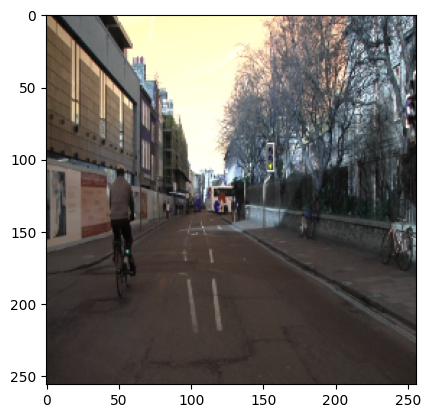

In [41]:
import matplotlib.pyplot as plt

n=1

#displaying test image
plt.imshow(test_images[1])

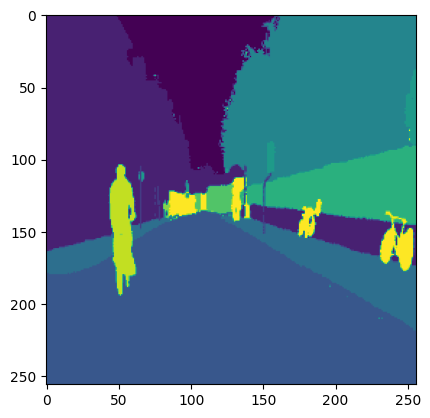

In [44]:
#display ground truth
plt.imshow(test_labels[n].squeeze(), cmap='viridis')



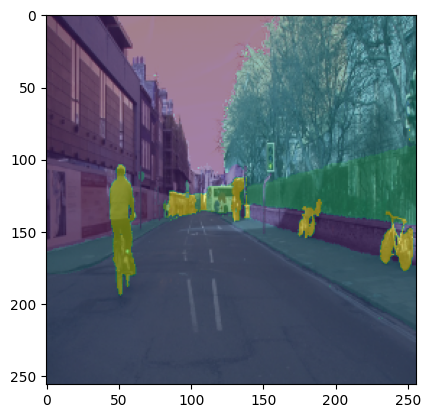

In [66]:

#ground truth superimposed on original image
fig, ax = plt.subplots()
ax.imshow(test_images[n])
ax.imshow(test_labels[n], alpha=0.5)
fig.show()

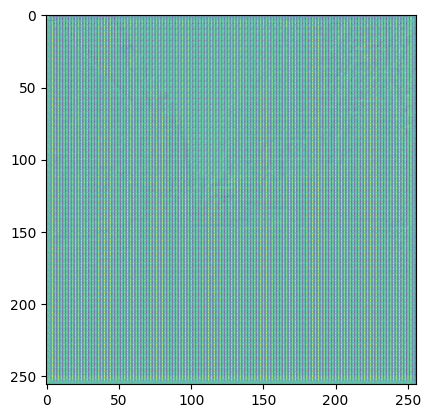

In [69]:

#predicted mask
plt.imshow(label[n],alpha=0.7)


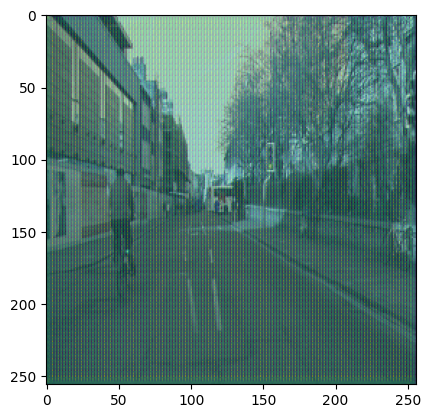

In [70]:

#predicted mask superimposed on original image
fig, ax = plt.subplots()
ax.imshow(test_images[n])
ax.imshow(label[n], alpha=0.5)
fig.show()

     